# Example 3: Walter 1994 in 2D. Migration of precipitation/dissolution fronts

This test problem is a one-dimensional, purely inorganic redox problem that was first presented by Walter et al. (1994). It  was subsequently used as a benchmark problem by Guerin and Zheng (1998). It demonstrates the evolution of some important geochemical processes that occur when acidic mine tailings leach into an anaerobic carbonate aquifer. Aqueous complexation and dissolution/precipitation are all considered as equilibrium reactions. If the reaction network defined by Walter et al. (1994) is used, the simulation includes 17 aqueous components, 15 of which are transported, 54 aqueous species and six minerals.

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
import flopy
from mf6rtm import utils
from mf6rtm import mf6rtm
import re
import difflib

prefix = 'ex3'
DT_FMT = "%Y-%m-%d %H:%M:%S"
dataws = os.path.join("data")
databasews = os.path.join("database")


#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 10  # Number of layers
Lx = 100 #m
ncol = 25 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 10.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 20  # Time step ($days$)
perlen = 2000  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#hydraulic properties
prsity = 0.35  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*10
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
l_hd = 12
r_hd = 10
strt = np.ones((nlay, nrow, ncol), dtype=float)*10
strt[:, 0, 0] = l_hd  # Starting head ($m$)

chdspd = [[(i, 0, 0), l_hd] for i in range(nlay)] # Constant head boundary $m$
chdspd.extend([(i, 0, ncol - 1), r_hd] for i in range(nlay))

# chdspd_tail = [[(i, 0, 0), l_hd] for i in range(0,3)]

#transport
dispersivity = 2.5 # Longitudinal dispersivity ($m$)
disp_tr_vert = 0.025 # Transverse vertical dispersivity ($m$)

icelltype = 0  # Cell conversion type

# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

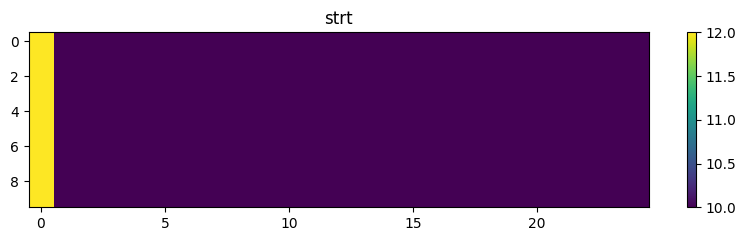

In [3]:
# # make a figure with subplots showing ibound and strt 
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(2, 1, 2)
ax.set_title('strt')
im = ax.imshow(strt[:, 0, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)


## Initialize Chemistry in Domain

In [4]:
files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

solutionsdf

,sol_bck,sol_tail
comp,,
pH,6.960000e+00,3.990000e+00
pe,1.670000e+00,7.690000e+00
C(+4),3.940000e-03,4.920000e-04
S(6),7.480000e-03,5.000000e-02
Fe(+2),5.390000e-05,3.060000e-02
Fe(+3),2.320000e-08,1.990000e-07
Mn(+2),4.730000e-05,9.830000e-06
Ca,6.920000e-03,1.080000e-02
Mg,1.960000e-03,9.690000e-04


In [5]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases


# equlibrium phases is a dictionary with keys as the phase number, values is another dictionary with phase name and an array of saturation indices as element 0 and concentrations as element 1. multiply the concentrations by 2
for key, value in equilibrium_phases.items():
    for k, v in value.items():
        v[-1] = mf6rtm.concentration_volbulk_to_volwater( v[-1], prsity)
equilibrium_phases

{1: {'Calcite': [0.0, 0.055714285714285716],
  'Siderite': [0.0, 0.012057142857142857],
  'Gibbsite': [0.0, 0.007171428571428572],
  'Fe(OH)3(a)': [0.0, 0.005314285714285715],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 1.1628571428571428]}}

In [6]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=int)
#slice nlay = 0 in sol_ic
# sol_ic[0:3,:,0] = 2


#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
eqp_ic = np.ones((nlay, nrow, ncol), dtype=int)*1
eqp_ic[3:,:,0]= -1 #boundary condation in layer 0 of no eq phases
equilibrium_phases.set_ic(eqp_ic)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}',f'mf6rtm'))

#set database
database = os.path.join(databasews, f'pht3d_datab_walter1994.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

#get phreeqc input
#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)

In [7]:
equilibrium_phases.data

{0: {'Calcite': [0.0, 0.055714285714285716],
  'Siderite': [0.0, 0.012057142857142857],
  'Gibbsite': [0.0, 0.007171428571428572],
  'Fe(OH)3(a)': [0.0, 0.005314285714285715],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 1.1628571428571428]}}

In [8]:
model.set_charge_offset(0.0)

In [9]:
#initialize model
model.initialize()

Using temperatue of 25.0 for all cells
Phreeqc initialized


## Initialize Inflow Chemistry

In [10]:
wellchem = mf6rtm.ChemStress('chdtail')
sol_spd = [2]
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)


Initializing ChemStress
ChemStress chdtail initialized


In [11]:
for i in range(len(chdspd)):
    if i<3:
        chdspd[i].extend(model.chdtail.data[0])
    else:
        chdspd[i].extend(np.zeros_like(model.chdtail.data[0]))
print(chdspd)

[[(0, 0, 0), 12, 110692.76183170642, 55550.81484856792, -0.07000281594576051, 4.287284994678123, 0.4905451627039263, 10.76806454719058, 0.11864811862182253, 30.509714628599696, 0.7906551098076068, 0.9661346802062664, 0.009800932823970994, 1.3858897889439776, 49.85215072264949, 2.073849468347822], [(1, 0, 0), 12, 110692.76183170642, 55550.81484856792, -0.07000281594576051, 4.287284994678123, 0.4905451627039263, 10.76806454719058, 0.11864811862182253, 30.509714628599696, 0.7906551098076068, 0.9661346802062664, 0.009800932823970994, 1.3858897889439776, 49.85215072264949, 2.073849468347822], [(2, 0, 0), 12, 110692.76183170642, 55550.81484856792, -0.07000281594576051, 4.287284994678123, 0.4905451627039263, 10.76806454719058, 0.11864811862182253, 30.509714628599696, 0.7906551098076068, 0.9661346802062664, 0.009800932823970994, 1.3858897889439776, 49.85215072264949, 2.073849468347822], [(3, 0, 0), 12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [(4, 0, 0), 12, 0.0, 

In [12]:
model.sconc['Charge']
model.components


['H',
 'O',
 'Charge',
 'Al',
 'C',
 'Ca',
 'Cl',
 'Fe',
 'K',
 'Mg',
 'Mn',
 'Na',
 'S',
 'Si']

## Build MF6 model

In [13]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        # cncspd = {0: [[(0, 0, col), conc] for col, conc in zip(range(ncol), model.sconc[c][0,0,:])]}
        cncspd = {0: [[(ly, 0, 0), model.sconc[c][ly,0,0]] for ly in range(3,nlay)]}

        # print(cncspd)
        cnc = flopy.mf6.ModflowGwtcnc(gwt,
                                        # maxbound=len(cncspd),
                                        stress_period_data=cncspd,
                                        save_flows=True,
                                        print_flows = True,
                                        pname="CNC",
                                        filename=f"{gwtname}.cnc",
                                        )
        cnc.set_all_data_external()
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['chd', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))*disp_tr_vert  # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [14]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Al
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---


--- Building MST package ---
--- Building OC package ---
Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Fe
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: K
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Mg
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Mn
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Na
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: S
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Si
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing solution package ims_1...
  writing solution package ims_2...
  writing solution package ims_3...
  writing solution package ims_4...
  writing solution package ims_5...
  writing solution package ims_6...
  writing solution package ims_7...
  writing solution package ims_8...
  writing solution package ims_9...
  writing solution package ims_10...
  writing solution package ims_11...
  writing solution package ims_12...
  writing solution package ims_13...
  writing package H.gwfgwt...
  writing package O.gwfgwt...
  writing package Charge.gwfgwt...
  writing package Al.gwfgwt...
  writing package C.gwfgwt...
  writing package Ca.gwfgwt...
  writing package Cl.gwfgwt...
  writing package Fe.gwfgwt..

    writing package oc...
  writing model Mn...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package cnc...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 7 based on size of stress_period_data
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Na...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package cnc...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 7 based on size of stress_period_data
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model S...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package cnc...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 7 based on size of stress_period_d

In [15]:
model.run_mup3d(sim, reaction=True)



-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Al, C, Ca, Cl, Fe, K, Mg, Mn, Na, S, Si


Starting transport solution at 2024-08-06 12:53:24

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 2 iters --- took 0.00037538 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 9 iters --- took 0.00045897 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 19 iters --- took 0.00055872 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 24 iters --- took 0.00064205 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 1 --- converged with 31 iters --- took 0.00074202 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 1 --- converged with 38 iters --- took 0.00082595 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Tra


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 2 --- converged with 0 iters --- took  0.0002922 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 2 --- converged with 6 iters --- took  0.0003922 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 2 --- converged with 14 iters --- took 0.00047552 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 2 --- converged with 18 iters --- took 0.00054275 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 2 --- converged with 25 iters --- took 0.00062552 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 2 --- converged with 31 iters --- took 0.00069218 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 2 --- conver


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 3 --- converged with 0 iters --- took  0.0002843 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 3 --- converged with 7 iters --- took  0.0003677 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 3 --- converged with 14 iters --- took 0.00045105 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 3 --- converged with 18 iters --- took 0.00053435 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 3 --- converged with 25 iters --- took 0.00061792 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 3 --- converged with 32 iters --- took 0.00071792 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 3 --- conver


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 4 --- converged with 0 iters --- took 0.00030897 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 4 --- converged with 7 iters --- took 0.00039275 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 4 --- converged with 14 iters --- took 0.00047605 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 4 --- converged with 17 iters --- took 0.00056105 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 4 --- converged with 24 iters --- took 0.00064463 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 4 --- converged with 31 iters --- took 0.00072778 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 4 --- conver


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 5 --- converged with 0 iters --- took 0.00027987 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 5 --- converged with 7 iters --- took 0.00036328 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 5 --- converged with 14 iters --- took 0.00044662 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 5 --- converged with 17 iters --- took 0.00051503 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 5 --- converged with 24 iters --- took 0.00059852 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 5 --- converged with 32 iters --- took 0.00069865 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 5 --- conver


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 6 --- converged with 0 iters --- took 0.00028152 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 6 --- converged with 7 iters --- took 0.00038325 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 6 --- converged with 14 iters --- took 0.00046653 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 6 --- converged with 17 iters --- took 0.00053327 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 6 --- converged with 24 iters --- took 0.00063347 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 6 --- converged with 31 iters --- took  0.0007188 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 6 --- conver


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 7 --- converged with 0 iters --- took 0.00028342 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 7 --- converged with 7 iters --- took 0.00037902 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 7 --- converged with 14 iters --- took 0.00046255 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 7 --- converged with 17 iters --- took  0.0005292 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 7 --- converged with 24 iters --- took 0.00062895 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 7 --- converged with 31 iters --- took 0.00071227 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 7 --- conver

Transport stress period: 1 --- time step: 8 --- converged with 7 iters --- took  0.0003926 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 8 --- converged with 14 iters --- took 0.00049193 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 8 --- converged with 17 iters --- took  0.0005586 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 8 --- converged with 24 iters --- took  0.0006589 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 8 --- converged with 31 iters --- took 0.00074195 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 8 --- converged with 37 iters --- took 0.00080862 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 8 --- converged with 41 iters --- took 0.0008


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 9 --- converged with 7 iters --- took 0.00038317 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 9 --- converged with 14 iters --- took 0.00046808 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 9 --- converged with 17 iters --- took  0.0005403 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 9 --- converged with 24 iters --- took  0.0006398 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 9 --- converged with 32 iters --- took 0.00072362 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 9 --- converged with 38 iters --- took 0.00082765 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 9 --- converg


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 10 --- converged with 0 iters --- took 0.00027993 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 10 --- converged with 6 iters --- took 0.00036348 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 10 --- converged with 13 iters --- took 0.00046328 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 10 --- converged with 16 iters --- took  0.0005302 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 10 --- converged with 23 iters --- took 0.00061355 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 10 --- converged with 30 iters --- took 0.00069687 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 10 ---


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 11 --- converged with 0 iters --- took 0.00029205 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 11 --- converged with 6 iters --- took 0.00036737 mins

Solution 2 fin


Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 12 --- converged with 0 iters --- took 0.00026647 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 12 --- converged with 6 iters --- took 0.00033312 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 12 --- converged with 13 iters --- took 0.00040825 mins

Solution 3 finalized

Solvi


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 13 --- converged with 0 iters --- took 0.00029938 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 13 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 14 --- converged with 0 iters --- took 0.00028285 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 14 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 15 --- converged with 0 iters --- took 0.00026892 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 15 --- converged 


Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 16 --- converged with 0 iters --- took 0.00031768 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 16 --- converged with 8 iters --- took 0.00045072 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 16 --- converged with 15 iters


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 17 --- converged with 0 iters --- took 0.00028343 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 17 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 18 --- converged with 0 iters --- took  0.0003418 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 18 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 19 --- converged with 0 iters --- took 0.00028358 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 19 --- converged 


Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 20 --- converged with 0 iters --- took  0.0003164 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 20 --- converged with 9 iters --- took  0.0004164 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 20 --- converged with 16 iters


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 21 --- converged with 0 iters --- took 0.00032582 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 21 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 22 --- converged with 0 iters --- took 0.00028335 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 22 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 23 --- converged with 0 iters --- took 0.00048333 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 23 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 24 --- converged with 0 iters --- took  0.0003498 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 24 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 25 --- converged with 0 iters --- took  0.0002668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 25 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 26 --- converged with 0 iters --- took  0.0003234 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 26 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 27 --- converged with 0 iters --- took 0.00040003 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 27 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 28 --- converged with 0 iters --- took 0.00030197 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 28 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 29 --- converged with 0 iters --- took 0.00029485 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 29 --- converged 


Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 30 --- converged with 0 iters --- took     0.0003 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 30 --- converged with 7 iters --- took 0.00039198 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stre


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 31 --- converged with 0 iters --- took 0.00033383 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 31 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 32 --- converged with 0 iters --- took 0.00025002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 32 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 33 --- converged with 0 iters --- took 0.00026663 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 33 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 34 --- converged with 0 iters --- took  0.0002503 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 34 --- converged 


Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 35 --- converged with 0 iters --- took 0.00030718 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 35 --- converged with 7 iters --- took 0.00043445 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 35 --- converged with 14 iters --- took 0.00051775 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 35 --- converged with 16 iters --- took 0.00057205 mins

Solution 4 finalized

Solving s


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 36 --- converged with 0 iters --- took 0.00030882 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 36 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 37 --- converged with 0 iters --- took 0.00029545 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 37 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 38 --- converged with 0 iters --- took 0.00028325 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 38 --- converged 


Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 39 --- converged with 0 iters --- took 0.00045005 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 39 --- converged with 7 iters --- took  0.0005667 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 39 --- converged with 15 iters --- took 0.00065002 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 39 --- converged with 17 iters ---


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 40 --- converged with 0 iters --- took 0.00026645 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 40 --- converged 


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 41 --- converged with 0 iters --- took 0.00028335 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 41 --- converged with 8 iters --- took 0.00038342 mins

Solution 2 fin


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 42 --- converged with 0 iters --- took 0.00026697 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 42 --- converged 


Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 43 --- converged with 0 iters --- took 0.00037363 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 43 --- converged with 8 iters --- took 0.00047228 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 43 --- converged with 15 iters --- took 0.00058177 mins

Solution 3 finalized

Solvi


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 44 --- converged with 0 iters --- took    0.00025 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 44 --- converged 


Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 45 --- converged with 0 iters --- took 0.00028333 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 45 --- converged with 7 iters --- took 0.00040542 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 45 --- converged with 15 iters --- took 0.00048875 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress perio


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 46 --- converged with 0 iters --- took 0.00030005 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 46 --- converged 


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 47 --- converged with 0 iters --- took 0.00028162 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 47 --- converged with 6 iters --- took 0.00038165 mins

Solution 2 fin


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 48 --- converged with 0 iters --- took 0.00023348 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 48 --- converged 


Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 49 --- converged with 0 iters --- took 0.00030847 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 49 --- converged with 6 iters --- took 0.00039178 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 49 --- converged with 14 iters --- took  0.0004918 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 49 --- converged with 16 iters ---


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 50 --- converged with 0 iters --- took 0.00026493 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 50 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 51 --- converged with 0 iters --- took 0.00028337 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 51 --- converged 


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 52 --- converged with 0 iters --- took 0.00030505 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 52 --- converged with 6 iters --- took  0.0003886 mins

Solution 2 fin


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 53 --- converged with 0 iters --- took  0.0002832 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 53 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 54 --- converged with 0 iters --- took 0.00027315 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 54 --- converged 


Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 55 --- converged with 0 iters --- took 0.00026668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 55 --- converged with 6 iters --- took 0.00033378 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 55 --- converged with 13 iters --- took 0.00041697 mins

Solution 3 finalized

Solvi


Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 56 --- converged with 0 iters --- took 0.00026668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 56 --- converged with 6 iters --- took 0.00033337 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stre


Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 57 --- converged with 0 iters --- took 0.00028325 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 57 --- converged with 6 iters --- took 0.00036473 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 57 --- converged with 14 iters --- took  0.0004685 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 57 --- converged with 16 iters --- took 0.00053332 mins

Solution 4 finalized

Solving s


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 58 --- converged with 0 iters --- took  0.0002648 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 58 --- converged 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 59 --- converged with 0 iters --- took 0.00027818 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 59 --- converged with 6 iters --- took 0.00036177 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 59 --- converged with 14 iters --- took  0.0004619 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 59 --- converged with 16 iters --- took  0.0005119 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 59 --- converged with 23 iters --- took  0.0006119 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 59 --- converged with 30 iters --- took 0.00072045 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 59 ---


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 60 --- converged with 6 iters --- took 0.00038185 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 60 --- converged with 14 iters --- took 0.00044852 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 60 --- converged with 16 iters --- took 0.00049852 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 60 --- converged with 23 iters --- took 0.00059032 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 60 --- converged with 30 iters --- took 0.00065698 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 60 --- converged with 37 iters --- took 0.00074032 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 60 --- 


Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 61 --- converged with 16 iters --- took 0.00053552 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 61 --- converged with 23 iters --- took 0.00063737 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 61 --- converged with 30 iters --- took 0.00071885 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 61 --- converged with 38 iters --- took 0.00081882 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 61 --- converged with 41 iters --- took 0.00091883 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 61 --- converged with 50 iters --- took  0.0010358 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 61 -

Transport stress period: 1 --- time step: 62 --- converged with 23 iters --- took 0.00055907 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 62 --- converged with 30 iters --- took 0.00065873 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 62 --- converged with 38 iters --- took  0.0007754 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 62 --- converged with 40 iters --- took 0.00084208 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 62 --- converged with 49 iters --- took 0.00095875 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 62 --- converged with 51 iters --- took  0.0010087 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 62 --- converged with 54 iters --- took


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 63 --- converged with 6 iters --- took 0.00038762 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 63 --- converged with 15 iters --- took 0.00048575 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 63 --- converged with 17 iters --- took 0.00053575 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 63 --- converged with 24 iters --- took 0.00061908 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 63 --- converged with 31 iters --- took 0.00074103 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 63 --- converged with 38 iters --- took 0.00090663 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 63 --- 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 64 --- converged with 0 iters --- took  0.0002667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 64 --- converged with 6 iters --- took 0.00033335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 64 --- converged with 15 iters --- took 0.00041668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 64 --- converged with 17 iters --- took 0.00048335 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 64 --- converged with 24 iters --- took 0.00056668 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 64 --- converged with 31 iters --- took  0.0006673 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 64 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 65 --- converged with 0 iters --- took 0.00028328 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 65 --- converged with 7 iters --- took 0.00036662 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 65 --- converged with 16 iters --- took 0.00044995 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 65 --- converged with 18 iters --- took 0.00049995 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 65 --- converged with 25 iters --- took 0.00058357 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 65 --- converged with 32 iters --- took 0.00065022 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 65 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 66 --- converged with 0 iters --- took 0.00033325 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 66 --- converged with 7 iters --- took  0.0004252 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 66 --- converged with 16 iters --- took 0.00052518 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 66 --- converged with 18 iters --- took 0.00059182 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 66 --- converged with 25 iters --- took 0.00068367 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 66 --- converged with 32 iters --- took 0.00076702 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 66 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 67 --- converged with 0 iters --- took 0.00029812 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 67 --- converged with 7 iters --- took 0.00043152 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 67 --- converged with 16 iters --- took  0.0005315 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 67 --- converged with 18 iters --- took 0.00058152 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 67 --- converged with 25 iters --- took 0.00065843 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 67 --- converged with 32 iters --- took  0.0007424 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 67 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 68 --- converged with 0 iters --- took 0.00026688 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 68 --- converged with 7 iters --- took 0.00033355 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 68 --- converged with 16 iters --- took 0.00042573 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 68 --- converged with 18 iters --- took 0.00049238 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 68 --- converged with 25 iters --- took 0.00060907 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 68 --- converged with 32 iters --- took  0.0006921 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 68 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 69 --- converged with 0 iters --- took 0.00028532 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 69 --- converged with 7 iters --- took 0.00036852 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 69 --- converged with 16 iters --- took 0.00046843 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 69 --- converged with 17 iters --- took 0.00053513 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 69 --- converged with 24 iters --- took 0.00061858 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 69 --- converged with 31 iters --- took 0.00070188 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 69 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 70 --- converged with 0 iters --- took 0.00028232 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 70 --- converged with 7 iters --- took 0.00036675 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 70 --- converged with 16 iters --- took 0.00046677 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 70 --- converged with 17 iters --- took  0.0005316 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 70 --- converged with 24 iters --- took 0.00059825 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 70 --- converged with 31 iters --- took 0.00069827 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 70 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 71 --- converged with 0 iters --- took  0.0002716 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 71 --- converged with 7 iters --- took 0.00035602 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 71 --- converged with 15 iters --- took 0.00045598 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 71 --- converged with 16 iters --- took 0.00054353 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 71 --- converged with 23 iters --- took 0.00072143 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 71 --- converged with 31 iters --- took 0.00082145 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 71 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 72 --- converged with 0 iters --- took 0.00031668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 72 --- converged with 8 iters --- took 0.00040002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 72 --- converged with 16 iters --- took 0.00048335 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 72 --- converged with 17 iters --- took 0.00053342 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 72 --- converged with 24 iters --- took 0.00061673 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 72 --- converged with 33 iters --- took 0.00070007 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 72 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 73 --- converged with 0 iters --- took 0.00026563 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 73 --- converged with 9 iters --- took  0.0003665 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 73 --- converged with 17 iters --- took 0.00046858 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 73 --- converged with 18 iters --- took 0.00051838 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 73 --- converged with 25 iters --- took 0.00060172 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 73 --- converged with 34 iters --- took 0.00071172 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 73 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 74 --- converged with 0 iters --- took 0.00026715 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 74 --- converged with 9 iters --- took 0.00035977 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 74 --- converged with 17 iters --- took 0.00046368 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 74 --- converged with 18 iters --- took 0.00053035 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 74 --- converged with 25 iters --- took 0.00061367 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 74 --- converged with 34 iters --- took  0.0007134 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 74 ---

Transport stress period: 1 --- time step: 75 --- converged with 18 iters --- took  0.0004791 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 75 --- converged with 25 iters --- took 0.00056215 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 75 --- converged with 34 iters --- took 0.00064547 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 75 --- converged with 42 iters --- took 0.00072882 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 75 --- converged with 44 iters --- took 0.00077882 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 75 --- converged with 53 iters --- took 0.00086215 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 75 --- converged with 55 iters --- took 0


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 76 --- converged with 9 iters --- took 0.00035878 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 76 --- converged with 17 iters --- took 0.00044183 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 76 --- converged with 18 iters --- took  0.0004918 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 76 --- converged with 25 iters --- took 0.00057515 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 76 --- converged with 33 iters --- took 0.00065847 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 76 --- converged with 41 iters --- took 0.00074182 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 76 --- 

Transport stress period: 1 --- time step: 77 --- converged with 17 iters --- took 0.00044313 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 77 --- converged with 18 iters --- took 0.00051052 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 77 --- converged with 25 iters --- took 0.00059382 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 77 --- converged with 33 iters --- took 0.00069395 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 77 --- converged with 41 iters --- took 0.00077837 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 77 --- converged with 43 iters --- took 0.00084502 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 77 --- converged with 52 iters --- to


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 78 --- converged with 9 iters --- took 0.00039993 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 78 --- converged with 17 iters --- took  0.0004666 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 78 --- converged with 18 iters --- took 0.00053327 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 78 --- converged with 25 iters --- took 0.00064993 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 78 --- converged with 33 iters --- took 0.00074998 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 78 --- converged with 41 iters --- took 0.00084998 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 78 --- 

Transport stress period: 1 --- time step: 79 --- converged with 19 iters --- took 0.00049968 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 79 --- converged with 26 iters --- took  0.0005833 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 79 --- converged with 34 iters --- took 0.00068302 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 79 --- converged with 42 iters --- took 0.00076682 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 79 --- converged with 44 iters --- took  0.0008333 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 79 --- converged with 53 iters --- took 0.00093333 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 79 --- converged with 55 iters --- took 0


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 80 --- converged with 9 iters --- took 0.00036668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 80 --- converged with 17 iters --- took 0.00043335 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 80 --- converged with 19 iters --- took 0.00050003 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 80 --- converged with 26 iters --- took 0.00056668 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 80 --- converged with 34 iters --- took 0.00065003 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 80 --- converged with 42 iters --- took 0.00073337 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 80 --- 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 81 --- converged with 0 iters --- took 0.00028402 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 81 --- converged with 9 iters --- took 0.00036668 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 81 --- converged with 17 iters --- took  0.0004518 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 81 --- converged with 19 iters --- took  0.0005185 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 81 --- converged with 26 iters --- took 0.00060182 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 81 --- converged with 34 iters --- took 0.00070177 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 81 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 82 --- converged with 0 iters --- took 0.00031643 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 82 --- converged with 9 iters --- took 0.00041643 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 82 --- converged with 17 iters --- took     0.0005 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 82 --- converged with 19 iters --- took 0.00056667 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 82 --- converged with 26 iters --- took  0.0006672 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 82 --- converged with 34 iters --- took 0.00075027 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 82 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 83 --- converged with 0 iters --- took 0.00030685 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 83 --- converged with 9 iters --- took 0.00040872 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 83 --- converged with 17 iters --- took 0.00050857 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 83 --- converged with 19 iters --- took 0.00057048 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 83 --- converged with 26 iters --- took 0.00065212 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 83 --- converged with 34 iters --- took 0.00077052 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 83 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 84 --- converged with 0 iters --- took 0.00029333 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 84 --- converged with 9 iters --- took 0.00040557 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 84 --- converged with 17 iters --- took 0.00049073 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 84 --- converged with 19 iters --- took  0.0005556 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 84 --- converged with 26 iters --- took 0.00063892 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 84 --- converged with 34 iters --- took 0.00073888 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 84 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 85 --- converged with 0 iters --- took 0.00031498 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 85 --- converged with 9 iters --- took 0.00044828 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 85 --- converged with 17 iters --- took 0.00054828 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 85 --- converged with 19 iters --- took 0.00061493 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 85 --- converged with 26 iters --- took 0.00069828 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 85 --- converged with 34 iters --- took 0.00079997 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 85 ---


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 86 --- converged with 0 iters --- took  0.0003026 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 86 --- converged with 9 iters --- took 0.00040298 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 86 --- converged with 17 iters --- took  0.0004863 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 86 --- converged with 19 iters --- took 0.00055268 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 86 --- converged with 26 iters --- took 0.00065277 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 86 --- converged with 34 iters --- took 0.00075288 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 86 ---


Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 87 --- converged with 9 iters --- took 0.00036908 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 87 --- converged with 17 iters --- took 0.00061487 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 87 --- converged with 19 iters --- took 0.00084953 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 87 --- converged with 26 iters --- took 0.00095498 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 87 --- converged with 34 iters --- took  0.0010551 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 87 --- converged with 42 iters --- took  0.0011545 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 88 --- converged with 0 iters --- took 0.00036667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 88 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 89 --- converged with 0 iters --- took 0.00029208 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 89 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 90 --- converged with 0 iters --- took 0.00030002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 90 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 91 --- converged with 0 iters --- took 0.00028335 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 91 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 92 --- converged with 0 iters --- took  0.0003003 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 92 --- converged 


Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 93 --- converged with 0 iters --- took 0.00026698 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 93 --- converged with 6 iters --- took  0.0003503 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stre


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 94 --- converged with 0 iters --- took 0.00026637 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 94 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 95 --- converged with 0 iters --- took 0.00031737 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 95 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 96 --- converged with 0 iters --- took 0.00031663 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 96 --- converged 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 97 --- converged with 0 iters --- took 0.00029972 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 97 --- converged 


Getting concentration arrays --- time step: 97 --- elapsed time: 1920.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 98 --- converged with 0 iters --- took 0.00036668 mins

Solution 1 finalized

Solving solution 


Getting concentration arrays --- time step: 98 --- elapsed time: 1940.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 99 --- converged with 0 iters --- took 0.00035032 mins

Solution 1 finalized

Solving solution 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 100 --- converged with 0 iters --- took 0.00030078 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 100 --- converge


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si





Reactive transport solution finished at 2024-08-06 12:53:46 --- it took:    0.36918 mins



MR BEAKER IMPORTANT MESSAGE: SOMETHING WENT WRONG. BUMMER



True

In [16]:
def get_lst_budget(ws='.', comp = '', start_datetime=None):
    budgetkey  = 'MASS BUDGET FOR ENTIRE MODEL'
    lst = flopy.utils.Mf6ListBudget(os.path.join(ws,f"{comp}.lst"), budgetkey = budgetkey)
    inc,cum = lst.get_dataframes(start_datetime=start_datetime)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "time"
    cum.index.name = "time"
    return inc, cum

In [17]:
inc, cum = get_lst_budget(ws = os.path.join(model.wd), comp = 'K')
inc

,storage-aqueous-in,chd-in,cnc-in,total-in,storage-aqueous-out,chd-out,cnc-out,total-out,in-out,percent-discrepancy
time,,,,,,,,,,
20.0,8.563000e-09,0.049416,0.009422,0.058838,0.029947,0.013813,0.015078,0.058838,7.600100e-10,0.0
40.0,3.434400e-09,0.049416,0.009042,0.058458,0.022958,0.013813,0.021687,0.058458,8.282800e-10,0.0
60.0,2.003000e-09,0.049416,0.008635,0.058051,0.019250,0.013813,0.024987,0.058051,-3.683400e-10,-0.0
80.0,1.397000e-09,0.049416,0.008257,0.057673,0.017111,0.013813,0.026748,0.057673,-2.839100e-09,-0.0
100.0,1.022000e-09,0.049416,0.007934,0.057350,0.015806,0.013813,0.027731,0.057350,-4.822500e-09,-0.0
...,...,...,...,...,...,...,...,...,...,...
1920.0,0.000000e+00,0.049416,0.006712,0.056128,0.002747,0.024091,0.029290,0.056128,-1.793900e-08,-0.0
1940.0,0.000000e+00,0.049416,0.006712,0.056128,0.002589,0.024249,0.029290,0.056128,-1.749100e-08,-0.0
1960.0,0.000000e+00,0.049416,0.006712,0.056128,0.002438,0.024401,0.029290,0.056128,-1.741700e-08,-0.0


## Plots

In [18]:
wd = os.path.join(f'{prefix}', f'pht3d')
# dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

#offset index of simapi by tstep
simapi.index = simapi.index + tstep
#simapi drop S-2 column
simapi.drop(columns = ['S-2'], inplace = True)
simapi


# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]

#read pht3dpy file
ucndic = {}
pht3dpy = os.path.join(wd, pht3dpy[0])
with open(pht3dpy, 'r') as f:
    # print(f.read())
    for l in f:
        n =re.findall(r'\d+', l.split()[-1])[-1]
        ucndic[l.split()[0].replace('_', "")] = f"PHT3D{n}.UCN"
        
for k,v in ucndic.items():
    ucn = flopy.utils.HeadFile(os.path.join(wd, v),text=f"concentration")
    results = ucn.get_alldata()
    ucndic[k] = results
timespht3d = ucn.get_times()
    
for var in simapi.columns:
    closest_match = find_closest_match(var, ucndic)
    if closest_match:
        ucndic[var] = ucndic.pop(closest_match)
        # print(f"Closest match to {var}: {closest_match}")
simapi.iloc[1:,:-7]

ucndic['K'].shape

(100, 1, 10, 25)

In [19]:
wd = os.path.join(f'{prefix}', f'mf6rtm')
# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

ucndic_mf6 = {}
for k in ucn_files:
    ucn = flopy.utils.HeadFile(os.path.join(wd, k),text=f"concentration")
    results = ucn.get_alldata()
    ucndic_mf6[f'{k.split(".")[0]}'] = results
times = ucn.get_times()

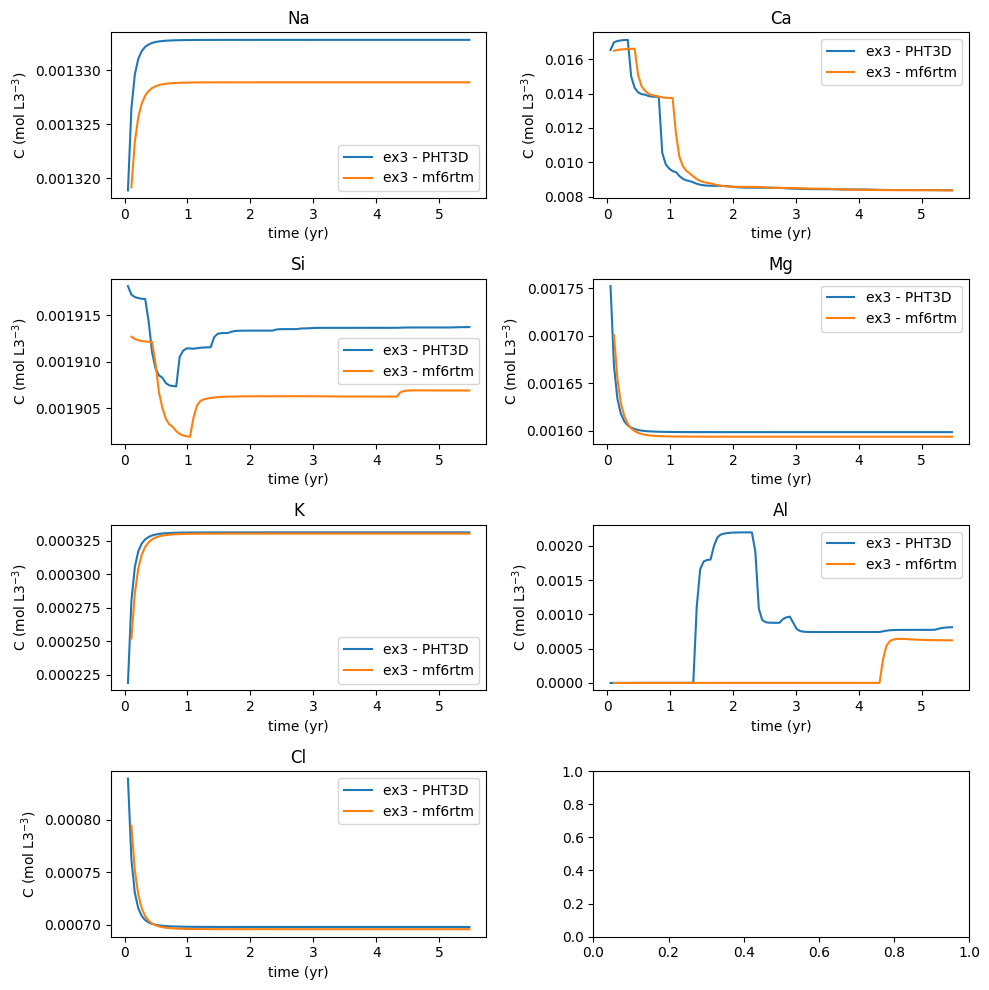

In [20]:
#get common keys from ucndic and ucndic_mf6
common_keys = set(ucndic.keys()).intersection(ucndic_mf6.keys())
common_keys

pncol=2
variables = common_keys

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 10))
for var, ax in zip(common_keys, axs.flatten()):
    ax.plot([x/365 for x in timespht3d], ucndic[var][:,0,0,0], label = f'{prefix} - PHT3D')
    ax.plot([x/365 for x in times[1:]], ucndic_mf6[var][1:,0,0,0]/1000, label = f'{prefix} - mf6rtm')

    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.8, xmax*1.2)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L3$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

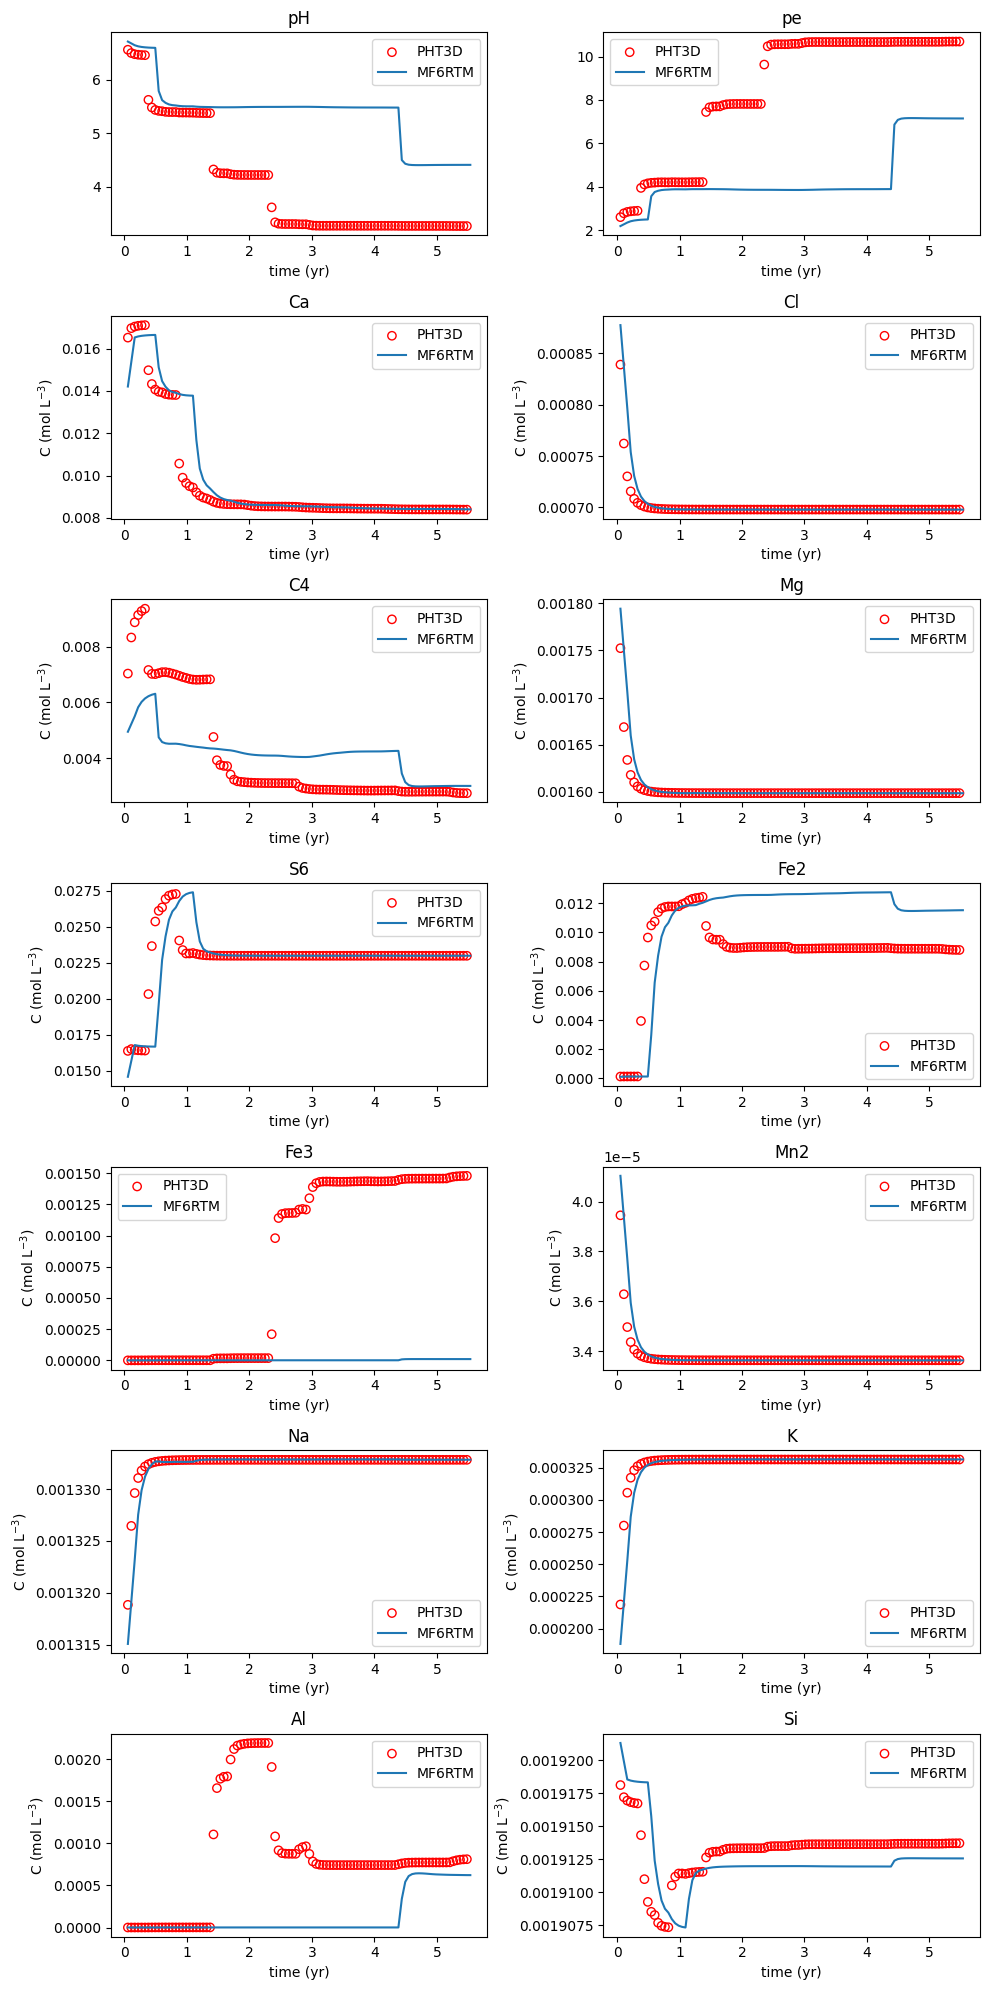

In [21]:
pncol=2
variables = simapi.iloc[:,1:-7 ].columns #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 20))
for var, ax in zip(simapi.iloc[:,1:-7 ].columns, axs.flatten()):

    df = simapi[simapi['cell'] == 0.].copy()
    t = df.index/365

    ax.scatter([x/365 for x in timespht3d], ucndic[var][:,0,0,0], label = f'PHT3D',
               facecolors='none', edgecolors='r',)
    ax.plot(t, df.loc[:, var].values, label = f'MF6RTM', 
                zorder = 10)
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.9, xmax*1.1)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

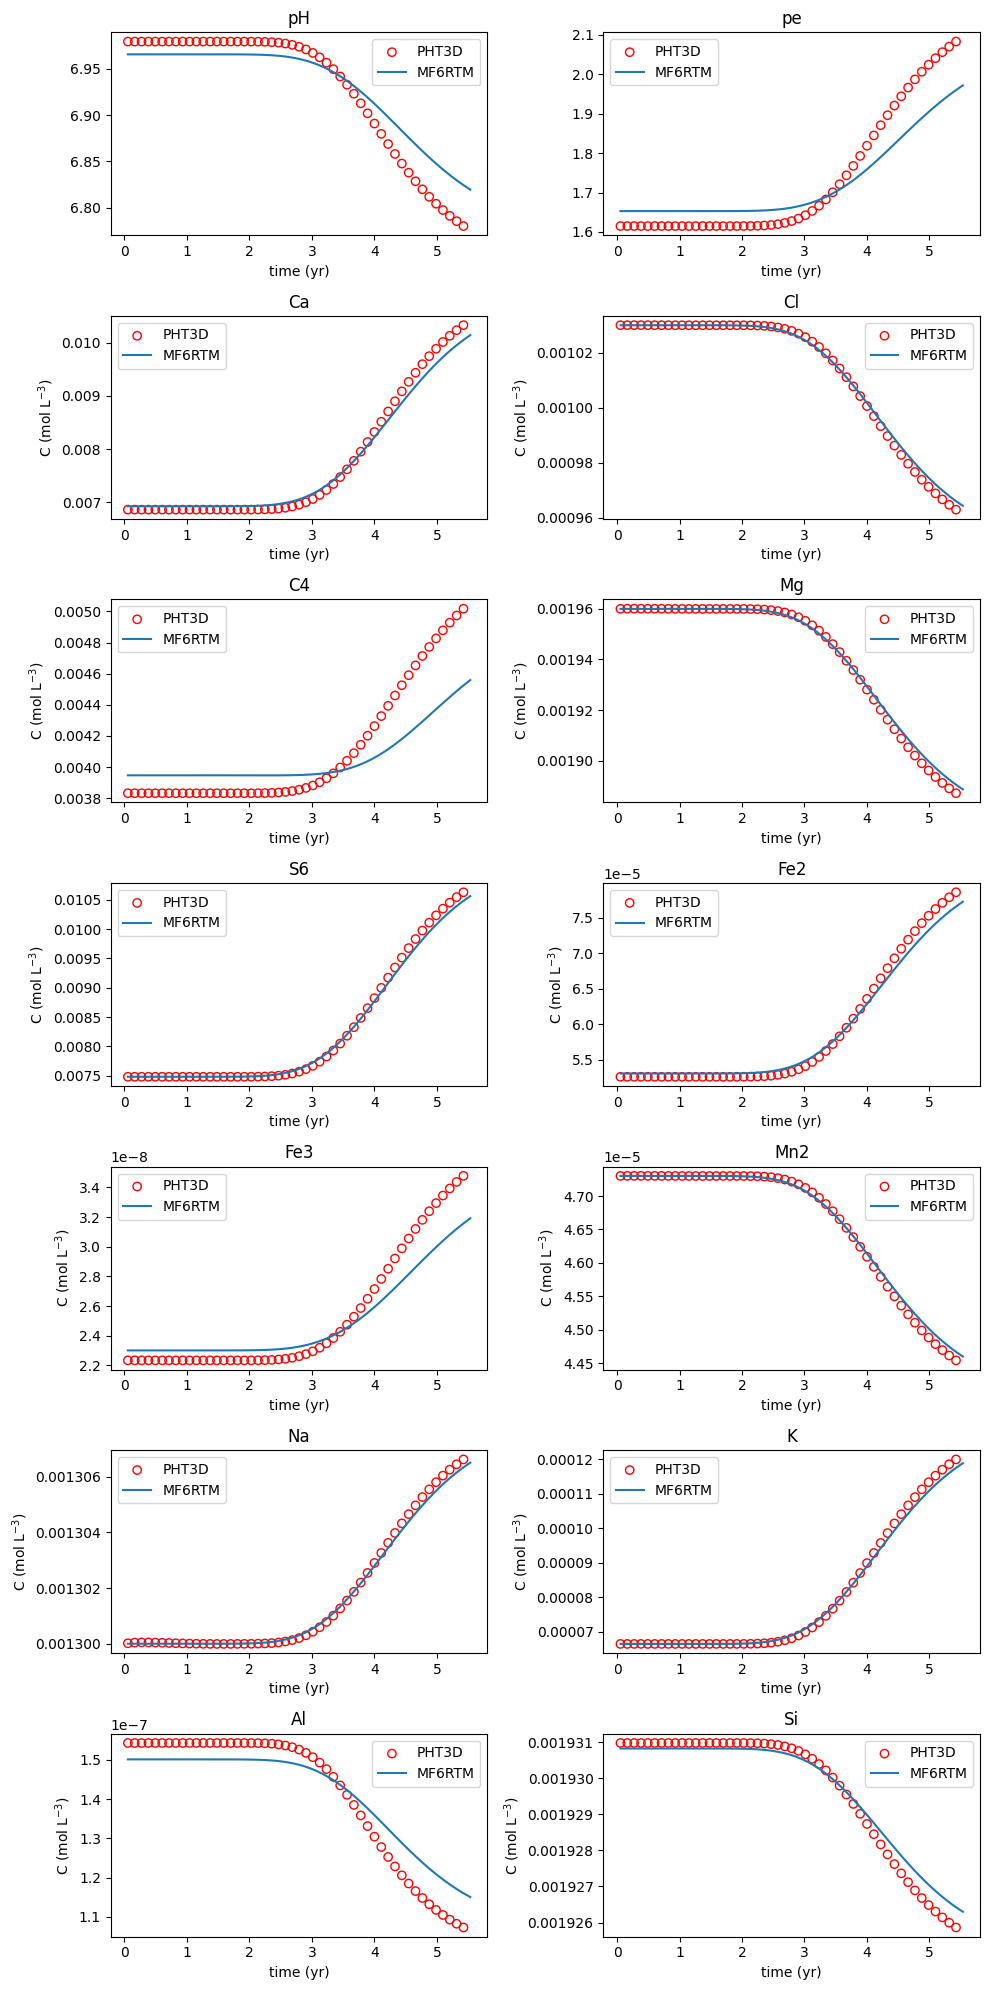

In [22]:
pncol=2
variables = simapi.iloc[:,1:-7 ].columns #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 20))
for var, ax in zip(simapi.iloc[:,1:-7 ].columns, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == 249.].copy()
    t = df.index/365

    ax.scatter([x/365 for x in timespht3d][::2], ucndic[var][:,0,-1,-1][::2], label = f'PHT3D',
               facecolors='none', edgecolors='r',)
    ax.plot(t, df.loc[:, var], label = f'MF6RTM', 
                zorder = 10)
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.9, xmax*1.1)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()
fig.savefig('ex3.png')

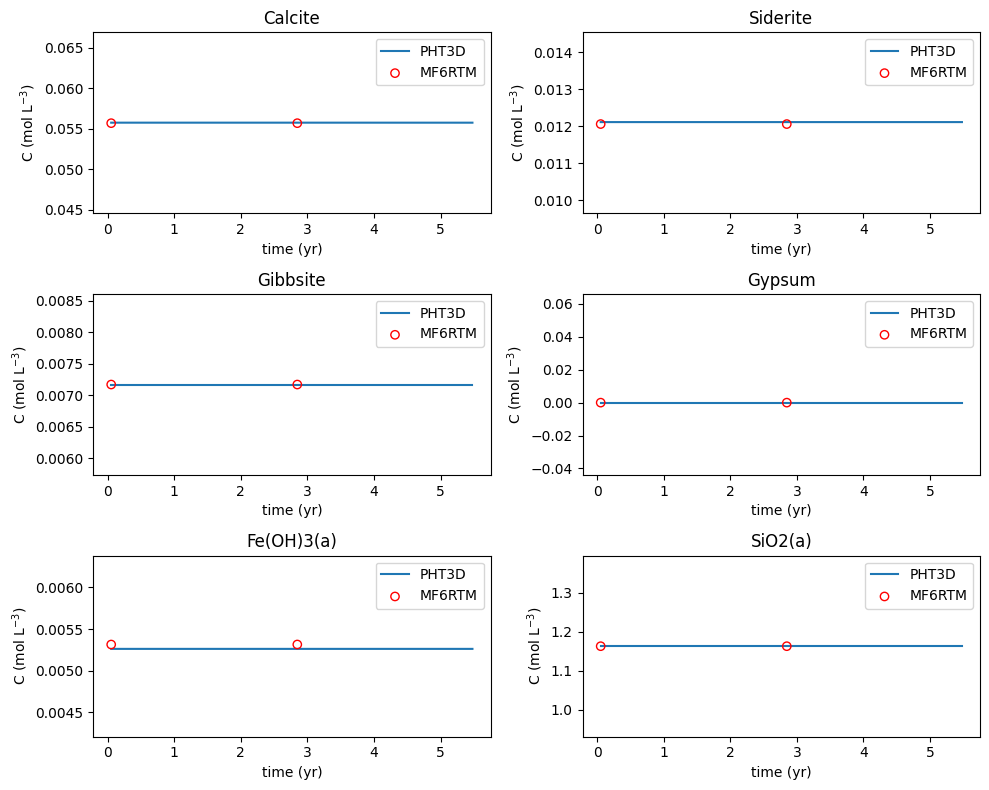

In [23]:
variables = simapi.iloc[:, -7: -1].columns #dissolved only
pncol=2
pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 8))
for var, ax in zip(variables, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == simapi['cell'].max()].copy()
    t = df.index/365
    ax.plot([x/365 for x in timespht3d], ucndic[var][:,0,-1,-1], label = f'PHT3D')


    ax.scatter(t[::50], df.loc[:, var][::50], label = f'MF6RTM', edgecolors='r', facecolors='none', zorder = 10)
    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    ax.set_ylim(xmin*.8, xmax*1.2) 
    
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

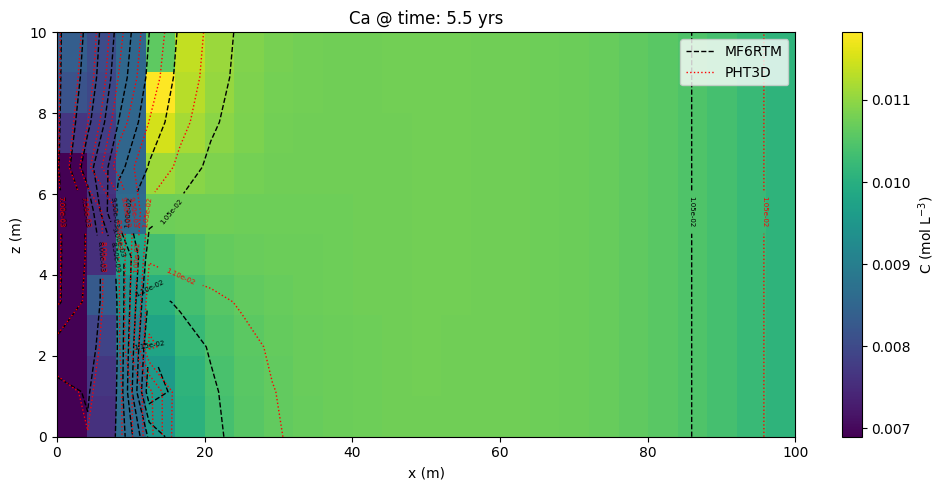

In [24]:
t = 2000
v = 'Ca'
# simapi.loc[t, v].values
# vmin = np.min(simapi.loc[t, v].values)
# vmax =  np.max(simapi.loc[t, v].values)
# levels = np.linspace(vmin, vmax, 4)
extent=[0, Lx, botm[-1], top]
fmt = '%1.2e'
# arr  = np.reshape(simapi.loc[t, v].values, (nlay, nrow, ncol))
arr = ucndic_mf6[v]
# arr = arr[1:]
# ucndic[var][:,-1,0,-1]
fig, axs = plt.subplots(1,1,figsize=(10, 5))
ax = axs
ax.set_title(f'{v} @ time: {t/365:.1f} yrs')
im1 = ax.imshow(arr[-1,:,0,:]/1000, aspect = 'auto', extent=extent)
cbar = plt.colorbar(im1, ax=ax, label = 'C (mol L$^{-3}$)')

# add contour labels
cntr1 = ax.contour(arr[-1,:,0,:]/1000, levels = 10, colors='k', 
                   linestyles = 'dashed', linewidths = 1, extent=extent)  
#add contour labels
ax.clabel(cntr1, inline=True, fontsize=5, fmt=fmt)

cntr2 = ax.contour(ucndic[v][-1,0,:,:], levels = 10, colors='r',
                   linestyles = 'dotted',  linewidths = 1, extent=extent) 
ax.clabel(cntr2, inline=True, fontsize=5, fmt=fmt)


ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
ax.legend([h1[0], h2[0]], [f'MF6RTM', f'PHT3D'])
fig.tight_layout()
fig.savefig(os.path.join(f'{prefix}_{v}_{t}.png'), dpi=600)

In [25]:
arr.shape[3]

25

<a list of 10 text.Text objects>

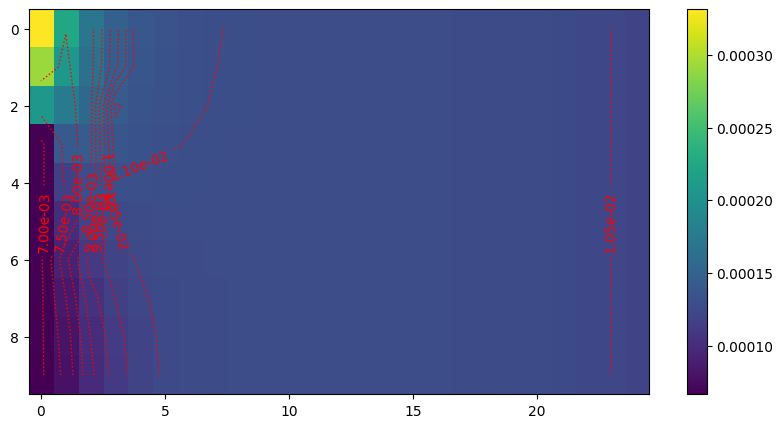

In [26]:
fmt = '%1.2e'

fig, axs = plt.subplots(1,1,figsize=(10, 5))
ax = axs
im2 = ax.imshow(ucndic['K'][-1,0,:,:], aspect = 'auto')
cbar = plt.colorbar(im2, ax=ax)
cntr2 = plt.contour(ucndic[v][-1,0,:,:], levels = 10, colors='r',
                   linestyles = 'dotted',  linewidths = 1) 
plt.clabel(cntr2, inline=True, fontsize=10, fmt=fmt)


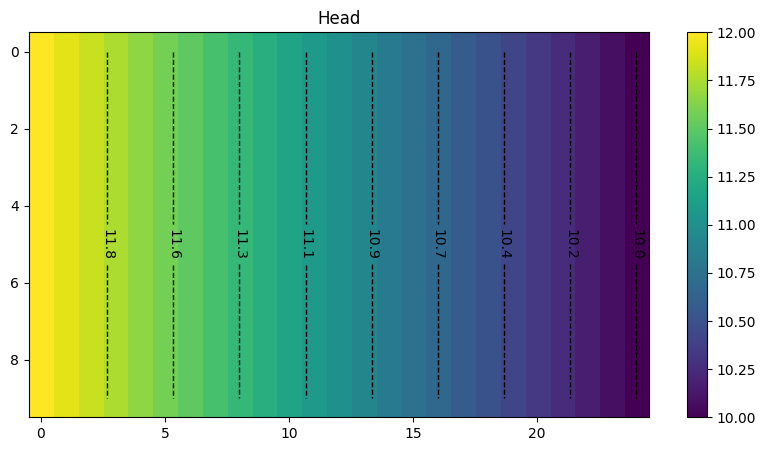

In [27]:
#plot heads of gwf model from mf6 sim with flopy
hds = flopy.utils.HeadFile(os.path.join(model.wd, 'gwf.hds'))
headmf6 = hds.get_alldata()

# plot with flopy
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Head')
im = ax.imshow(headmf6[-1, :, 0, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)
#add contours   
levels = np.linspace(headmf6[-1, :, 0, :].min(), headmf6[-1, :, 0, :].max(), 10)
cntr = ax.contour(headmf6[-1, :, 0, :], levels = levels, colors='k', linestyles = 'dashed', linewidths = 1)
ax.clabel(cntr, inline=True, fontsize=10, fmt='%1.1f')
plt.show()


<a list of 9 text.Text objects>

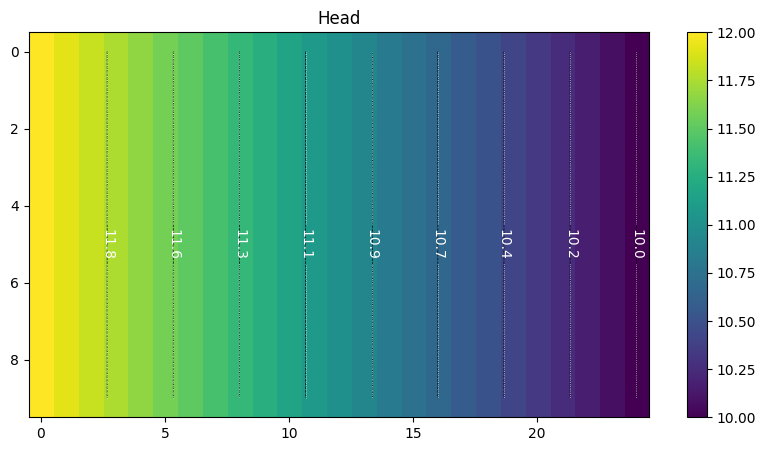

In [28]:
#plot the heads from pht3d model
wd = os.path.join(f'{prefix}',f'pht3d')

hds = flopy.utils.HeadFile(os.path.join(wd, f'walter1994.head'))
head = hds.get_alldata()
head.shape

#plot heads
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Head')
im = ax.imshow(head[-1, 0, :, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)
#add contours
levels = np.linspace(head[0, 0, :, :].min(), head[0, 0, :, :].max(), 10)
cntr = ax.contour(head[0, 0, :, :], levels = levels, colors='k', linestyles = 'dashed', linewidths = 0.5)

levels = np.linspace(headmf6[-1, :, 0, :].min(), headmf6[-1, :, 0, :].max(), 10)
cntr = ax.contour(headmf6[-1, :, 0, :], levels = levels, colors='w', linestyles = 'dotted', linewidths = 0.5)
ax.clabel(cntr, inline=True, fontsize=10, fmt='%1.1f')
